## Feature Engineering_실습 코드 순서

1) Data Cleaning & Preprocessing
- Outlier
- Missing value
- Skewness

2) Scaling
- Standardization
- Normalization

3) Encoding
- Label Encoding
- Onehot Encoding

4) Feature Selection
- Filter Methods
- Wrapper Methods
- Embedded Methods

5) Dimension Reduction
- PCA
- LDA
- KPCA

6) Feature Generation/Construction
- 'Name' Feature Generation

# 0. Data / Library import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy import stats

In [2]:
# 준비된 타이타닉 데이터셋으로 실습을 진행하겠습니다.
df = pd.read_csv('./titanic.csv')

In [3]:
# 총 891개의 데이터 포인트와 12개의 feature 를 가진 DataFrame 입니다.
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


# 1. Data Cleaning & Preprocessing

In [4]:
# 가장 먼저 .describe()를 통해 기초통계량을 확인합니다.
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


각 feature의 기초통계량을 살펴보면 특이한 부분들을 발견할 수 있습니다.
1. 먼저 Age 특성의 count는 714개 입니다. Missing Value가 있다는 것을 알 수 있습니다.
2. Fare의 max값이 512.3 입니다. 3분위 값이 31인 것에 비해 매우 높습니다. 이상치라고 볼 수 있습니다.

모델의 분석 성능을 높이기 위해 이러한 값을 조정해주도록 하겠습니다.

## 1.1. Outlier

Outlier를 가장 명확하게 확인하는 방법은 boxplot을 활용하는 것입니다.<br>
보통 상자의 위, 아래에 가로로 뻗어나간 선(whisker)을 기준으로 그 밖에 있는 값을 Outlier로 추정합니다.

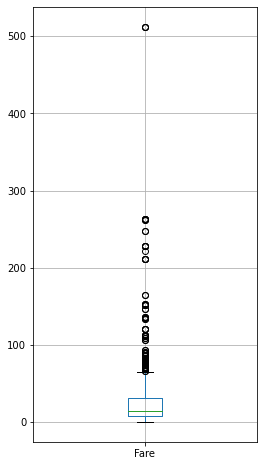

In [5]:
df.boxplot(column = ['Fare'], figsize=(4, 8))
plt.show()

Fare의 값을 살펴보면 꽤나 많은 값들이 upper whisker(상단 가로줄)을 넘어갑니다.<br>
대략 70불 이상이면 이상치라고 볼 수 있습니다.

In [6]:
# 70불 이상의 값이 몇 개인지 카운트
df[df.Fare > 70]['Fare'].count()

105

105개입니다. 그러나 이 값들을 모두 조정해버리면 모델의 성능에 오히려 부정적인 영향을 미칠 수 있습니다.<br>
총 데이터 수가 900개가 안되기 때문이죠. 10%가 넘는 수치를 조정하는 것은 위험합니다.<br>
그렇기 때문에 맨 위에 있는 500달러가 넘어가는 값만 조정해주겠습니다.

In [7]:
df[df.Fare > 500] # Fare가 500이상인 행을 불러봅니다.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


총 3개의 값이 있습니다. 그리고 분석가는 이상치를 처리할 방법을 선택 해야 합니다.
1. 이상치를 제거한다.
2. 이상치를 다른 값으로 치환한다.

두 가지 모두 살펴보겠습니다.

### 1.1.1. 이상치 제거하기

이상치를 제거하는 방법은 간단합니다. 해당 값을 제외한 값들로 다시 객체를 지정해주면 됩니다.

In [8]:
df_outlier_eliminated = df[df.Fare < 500] # Fare가 500이하인 행을 새로운 DataFrame에 할당

In [9]:
df_outlier_eliminated.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,888.000000,888.000000,888.000000,711.000000,888.000000,888.000000,888.000000
mean,445.618243,0.381757,2.313063,29.675345,0.524775,0.381757,30.582164
std,257.405474,0.486091,0.834007,14.552495,1.104186,0.806949,41.176366
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,445.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.771850
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,263.000000


Fare의 max값이 263으로 줄었습니다. 동시에 전체 데이터 수가 888개로 줄었습니다.

### 1.1.2. 이상치 대체하기

이상치 값을 대체하기 위해 이상치 값을 제외한 값 중 가장 큰 값을 찾아옵니다.

In [10]:
max(df[df.Fare < 500]['Fare'])

263.0

263의 값입니다. 이 값으로 500 이상의 값들을 치환해줍니다.

In [11]:
fare_max = max(df[df.Fare < 500]['Fare']) # 263을 객체로 할당해줍니다.
df.loc[df.Fare > 500, 'Fare'] = fare_max # .loc 함수를 통해 500 이상의 값을 fare_max로 할당해줍니다.

In [12]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,31.364716
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,43.257927
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,263.000000


891개의 모수를 유지하면서 max 값을 263으로 바꿔주었습니다.

## 1.2. Missing Value(결측치)

Missing Value는 명확하게 확인이 가능합니다. 그리고 처리하는 방법도 앞서 실습한 Outlier와 유사합니다.
1. 결측치를 제거한다.
2. 결측치를 다른 값으로 치환해준다.

In [13]:
# Age 특성의 결측치를 확인합니다.
df.Age.isnull().sum()

177

결측치는 총 177개가 있습니다.

### 1.2.1 Missing Value 제거

제거해버리는 방법은 Outlier를 제거하는 방법을 동일하게 써도 되지만, 내장된 함수를 사용할 수도 있습니다.

In [14]:
# .dropna()를 사용해 결측치가 포함된 행을 제거해버릴 수 있습니다.
# subset=[] 을 통해 특정한 feature만을 지정해줄 수 있습니다.
df.dropna(subset=['Age'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


그러나 177개를 전부 제거해버리면 데이터가 적어집니다. 그렇기 때문에 다른 값으로 치환하는게 합리적으로 보입니다.

### 1.2.2. Missing Value 채우기

In [15]:
# .fillna() 함수를 활용하면 간단하게 채워줄 수 있습니다.
# 어떤 방식으로 채워줄지 method를 지정해주어야 합니다.
# ffill 은 forward fill로 바로 위에 나온 값으로 채워줍니다.
# bfill 은 backword fill로 바로 뒤에 나올 값으로 채워줍니다.

age_ffilled = df['Age'].fillna(method='ffill')

In [16]:
# 결측치가 사라진 것을 확인합니다.
age_ffilled.isnull().any()

False

In [17]:
# .fillna() 함수 안에는 특정 값을 지정해줄 수도 있습니다.
# 이 방법을 활용해서 평균 값으로 치환해줄 수도 있습니다.
df['Age'] = df['Age'].fillna(np.mean(df.Age))

### 1.2.3. 범주형 데이터의 Missing Value 채우기

타이타닉 데이터셋에는 범주형 데이터가 많습니다. 수치형 데이터가 아닌 범주형 데이터의 Missing Value를 채우는 방법을 알아보겠습니다.

범주형 데이터는 평균이나 최대값 등이 존재하지 않습니다. 그렇기에 대체로 최빈값으로 대체합니다.

In [18]:
# Embarked 특성에 결측치가 있는지 확인
df.Embarked.isnull().any()

True

In [19]:
# 결측치 개수 확인
df.Embarked.isnull().sum()

2

In [20]:
# 해당 feature의 value_counts() 확인
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

'S' 값이 644개로 최빈값입니다. 이 값으로 결측치를 채워줍니다.

In [21]:
# 앞서 실습하였던 방법을 동일하게 사용합니다.
df['Embarked'] = df['Embarked'].fillna('S')

In [22]:
# 결측치가 있는지 확인
df.Embarked.isnull().any()

False

## 1.3. Skewness

Skewness(왜도)를 확인하는 방법은 scipy패키지에서 제공하는 skew()함수를 활용하거나, 그래프를 통해서 시각적으로 확인하는 방법이 있습니다. 보통 왜도가 2가 넘어가면 편향되었다고 판단합니다. Skewness 값을 추출하는 공식은 아래와 같습니다.

>$$
{Skewness} = \frac{3({Mean - Median})}{Standard Deviation}
$$

In [23]:
# 먼저 왜도가 얼마나 되는지 측정해보겠습니다.
sc.stats.skew(df['Fare'])

3.204357326048027

2가 넘습니다. 왜도를 조정하는 방법은 log를 취하는 것입니다.

In [24]:
# 간단한 lambda 함수로 Fare 값에 log를 취해줍니다.
fare_loged = df['Fare'].apply(lambda x: np.log(x + 1))

In [25]:
# 조정한 왜도 값을 확인해줍니다.
sc.stats.skew(fare_loged)

0.3438828547065768

# 2. Scaling

In [26]:
# Scaling은 sklearn의 preprocessing 함수를 통해 쉽게 처리할 수 있습니다.
from sklearn import preprocessing

In [27]:
# 수치형 변수 중에 'Fare' 라는 변수 scaling 시켜보겠습니다.
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,31.364716
std,257.353842,0.486592,0.836071,13.002015,1.102743,0.806057,43.257927
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,263.000000


## 2.1. Normalization(정규화)

특성 스케일을 0~n 사이의 범위로 조정하는 과정<br>

>$$
{x'_i} = \frac{{x_i}- {min(x)}}{{max(x)} - {min(x)}}
$$

In [28]:
# MinMaxScaler 객체를 생성해줍니다.
# feature_range를 통해 정규화 범위를 지정해줍니다.
mx_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

# sklearn 라이브러리의 MinMaxScaler는 입력 인자를 array로 받습니다.
# 따라서 df의 Age열을 array로 변환한 객체를 생성합니다.
fare_array = np.array(df['Fare']).reshape(-1, 1)

# .fit_transform() 을 활용하여 적용해줍니다.
mx_scaled_fare = mx_scaler.fit_transform(fare_array)

In [29]:
# 0~1 사이의 값으로 정규화 된 값을 확인할 수 있습니다.
mx_scaled_fare[:5]

array([[0.02756654],
       [0.27103916],
       [0.03013308],
       [0.20190114],
       [0.03060837]])

In [30]:
# df에 새로운 특성으로 추가해줍니다.
df['mx_scaled_fare'] = mx_scaled_fare
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,mx_scaled_fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.027567
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.271039
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.030133
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.201901
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.030608


## 2.2. Standardization(표준화)

특성의 평균이 0이고, 표준편차가 1인 Z분포를 만드는 것

>$$
{x'_i} = \frac{{x_i}- {\bar{x}}}{{\sigma}}
$$

In [31]:
# StandardSclaer 객체를 생성해줍니다.
sd_scaler = preprocessing.StandardScaler()

# sklearn 라이브러리의 MinMaxScaler는 입력 인자를 array로 받습니다.
# 따라서 df의 Age열을 array로 변환한 객체를 생성합니다.
fare_array = np.array(df['Fare']).reshape(-1, 1)

# .fit_transform() 을 활용하여 적용해줍니다.
sd_scaled_fare = sd_scaler.fit_transform(fare_array)

In [32]:
# 표준화 된 값을 확인할 수 있습니다.
sd_scaled_fare[:5]

array([[-0.5577766 ],
       [ 0.9233222 ],
       [-0.54216376],
       [ 0.50274004],
       [-0.5392725 ]])

In [33]:
# df에 새로운 특성으로 추가해줍니다.
df['sd_scaled_fare'] = sd_scaled_fare
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,mx_scaled_fare,sd_scaled_fare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.027567,-0.557777
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.271039,0.923322
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.030133,-0.542164
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.201901,0.502740
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.030608,-0.539272


# 3. Encoding

## 3.1. Label Encoding

Label Encoder는 sklearn에서 제공하는 함수를 활용합니다.

In [34]:
# 라벨 값을 저장해줄 LabelEncoder 객체를 할당합니다.
le = preprocessing.LabelEncoder()

In [35]:
# 'Embarked' feature는 3가지 값을 가지고 있습니다.
# 이 세개의 값을 정수로 라벨링 할 것입니다.
df.Embarked.unique()

array(['S', 'C', 'Q'], dtype=object)

In [36]:
# 해당 feature의 값을 list 형태로 집어넣어줍니다.
Emabarked_listed = df.Embarked.tolist()

# .fit 함수로 학습시킵니다.
le.fit(Emabarked_listed)

LabelEncoder()

In [37]:
# le의 라벨을 확인합니다.
le.classes_

array(['C', 'Q', 'S'], dtype='<U1')

In [38]:
# 학습된 라벨로 feature의 값을 변환시킵니다.
label_encoded_embarked = le.transform(Emabarked_listed)
label_encoded_embarked[:5]

array([2, 0, 2, 2, 2], dtype=int64)

In [39]:
# 인코더를 통해 디코딩을 실행할 수도 있습니다.
label_decoded_embarked = le.inverse_transform(label_encoded_embarked)
label_decoded_embarked[:5]

array(['S', 'C', 'S', 'S', 'S'], dtype='<U1')

## 3.2. OneHot Encoding

원핫 인코더 또한 sklearn에서 제공하지만, pandas를 활용하는 것이 더 편리합니다.

In [40]:
# pandas.get_dummies()를 활용하면 해당 DataFrame의 범주형 feature들을 자동으로 onehot encoding 시킬 수 있습니다.
pd.get_dummies(df, # 인코딩이 필요한 DataFrame
               columns=['Sex', 'Embarked'], # 인코딩이 필요한 feature를 지정할 수 있습니다.
               prefix='', # 인코딩된 feature 이름 뒤에 붙일 라벨
               prefix_sep='_', # 인코딩된 feature 라벨 앞에 붙는 구분자
               drop_first=False # 원핫인코딩은 자유도 n-1을 가지기 때문에, 원핫인코딩 후 하나의 feature는 의미가 없습니다. 그래서 지워줄 수 있습니다.
              ).head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,mx_scaled_fare,sd_scaled_fare,_female,_male,_C,_Q,_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0.027567,-0.557777,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0.271039,0.923322,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.030133,-0.542164,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0.201901,0.502740,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0.030608,-0.539272,0,1,0,0,1


In [41]:
df_encoded = pd.get_dummies(df, columns=['Sex', 'Embarked'], drop_first=False)
df_encoded.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,mx_scaled_fare,sd_scaled_fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0.027567,-0.557777,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0.271039,0.923322,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0.030133,-0.542164,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0.201901,0.502740,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0.030608,-0.539272,0,1,0,0,1


# 4. Feature Selection

feature selection을 위해서 데이터의 타겟값을 분리시켜주어야 합니다.

In [42]:
# 학습이 불가능한 범주형 변수들을 없애줍니다.
df_cleaned = df_encoded.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'mx_scaled_fare', 'sd_scaled_fare'],
                             axis=1)
df_cleaned.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [43]:
# 종속변수와 독립변수를 분리해줍니다.
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']

X = df_cleaned[features]
y = df_cleaned['Survived']

In [44]:
X.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0
2,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1
4,3,35.0,0,0,8.0500,0,1,0,0,1


In [45]:
y[:5]

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

## 4.1. Filter Methods

In [46]:
# Filter Methods는 sklearn에서 제공하는 SelectKBest를 활용합니다.
# chi2 는 카이제곱검정입니다.

from sklearn.feature_selection import SelectKBest, chi2

In [47]:
skb = SelectKBest(score_func=chi2, # chi2로 지정해줍니다.
                  k='all') # k 개수를 지정할 수 있습니다. 모든 값을 보도록 하겠습니다.
result = skb.fit(X, y)

In [48]:
np.set_printoptions(precision=3)
print(result.scores_)

[3.087e+01 2.469e+01 2.582e+00 1.010e+01 3.899e+03 1.703e+02 9.270e+01
 2.046e+01 1.085e-02 5.489e+00]


In [49]:
chi2 = pd.DataFrame(result.scores_, index=X.columns, columns=['score'])

In [50]:
chi2.sort_values('score', ascending=False)

,score
Fare,3899.134564
Sex_female,170.348127
Sex_male,92.702447
Pclass,30.873699
Age,24.687926
Embarked_C,20.464401
Parch,10.097499
Embarked_S,5.489205
SibSp,2.581865
Embarked_Q,0.010847


'Fare', 'Sex' 변수들이 높은 계수를 가지는 것을 확인할 수 있습니다.

## 4.2. Wrapper Methods

In [51]:
# Wrapper Methods는 RFE라고하는 알고리즘을 활용합니다.
# RFE는 Recursive Feature Elimination이라고 하여, 반복하여 변수를 제거해나가는 방식입니다.
# 마찬가지로 sklearn이 제공하는 함수를 활용합니다.

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [52]:
model = LogisticRegression()
rfe = RFE(model,
          3) # feature의 개수를 지정할 수 있습니다. 3개로 해봅니다.
rfe_fit = rfe.fit(X, y)

C:\Users\Wyatt\anaconda3\envs\wyatt37\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass n_features_to_select=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\Users\Wyatt\anaconda3\envs\wyatt37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\Wyatt\anaconda3\envs\wyatt37\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the 

In [53]:
print("Num Features: %s" % (rfe_fit.n_features_))
print("Selected Features: %s" % (rfe_fit.support_))
print("Feature Ranking: %s" % (rfe_fit.ranking_))

Num Features: 3
Selected Features: [ True False False False False  True  True False False False]
Feature Ranking: [1 7 3 5 8 1 1 4 6 2]


3개의 feature를 지정하도록 입력했고, 3개의 feature만 True로 반환합니다.

In [54]:
# rank를 확인할 수도 있습니다.
rfe_select = pd.DataFrame(rfe_fit.support_.tolist(), index=X.columns, columns=['true'])
rfe_select['rank'] = rfe_fit.ranking_.tolist()
rfe_select.sort_values('rank')

,true,rank
Pclass,True,1
Sex_female,True,1
Sex_male,True,1
Embarked_S,False,2
SibSp,False,3
Embarked_C,False,4
Parch,False,5
Embarked_Q,False,6
Age,False,7
Fare,False,8


'Pclass', 'Sex' 변수들이 높은 계수를 가지는 것을 확인할 수 있습니다.

## 4.3. Embedded Methods

Embedded Methods는 RandomForest, Ridge 모델 등을 활용할 수 있습니다. 실습에서는 Ridge를 활용하겠습니다.

In [55]:
# 역시나 sklearn이 제공합니다.
from sklearn.linear_model import RidgeClassifier

In [56]:
# ridge 모델에 학습시킵니다.
ridge = RidgeClassifier(alpha=1.0)
ridge.fit(X, y)

RidgeClassifier()

In [57]:
# 각 feature별 계수를 확인할 수 있습니다.
ridge.coef_

array([[-3.531e-01, -1.174e-02, -8.090e-02, -2.918e-02,  3.055e-04,
         5.042e-01, -5.042e-01,  4.738e-02,  4.050e-02, -8.789e-02]])

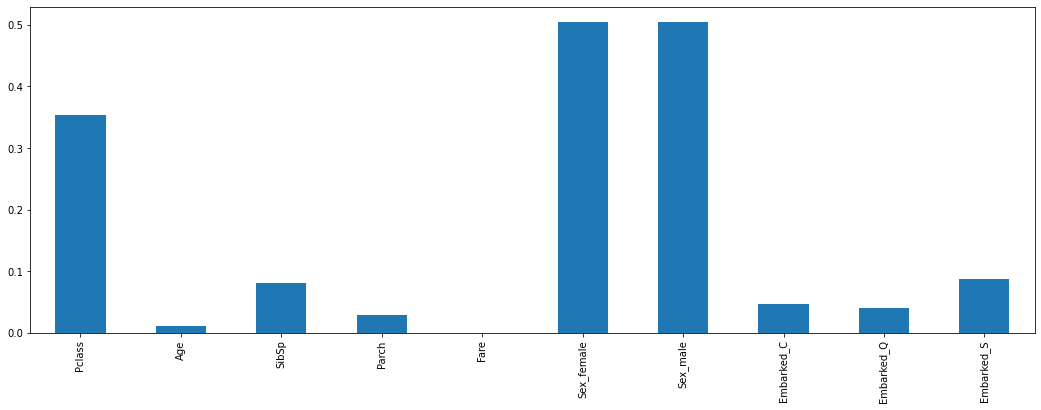

In [58]:
# 조금 더 직관적으로 확인하기 위한 작업을 해주겠습니다.

# 먼저 계수를 DataFrame으로 가져와줍니다.
ridge_select = pd.DataFrame(ridge.coef_[0],
                            index=X.columns, columns=['score'])

# 계수는 음과 양의 값을 가지지만, 편히 보기 위해서는 절대값을 취해줍니다.
ridge_select = ridge_select.apply(lambda x: np.abs(x))

# 바 그래프를 통해 눈으로 확인하겠습니다.
ridge_select.score.plot(kind='bar', figsize=(18, 6))
plt.show()

'Pclass', 'Sex' 변수들이 높은 계수를 가지는 것을 확인할 수 있습니다.

# 5. Dimension Reduction

## 5.1. PCA

In [59]:
# sklearn 에서 제공하는 PCA 함수를 활용합니다.
from sklearn.decomposition import PCA

In [60]:
pca = PCA(n_components=0.99, # 원본 특성의 99% 분산을 유지한다는 뜻입니다.
          whiten=True) # whiten 값을 True로 지정하여 주성분의 값을 평균이 0, 분산이 1인 분포로 만듭니다.

In [61]:
# 앞서 독립변수만을 지정해 주었던 X 를 적용시켜줍니다.
features_pca = pca.fit_transform(X)

In [62]:
print("원본 특성 개수: ", X.shape[1])
print("줄어든 특성 개수: ", features_pca.shape[1])

원본 특성 개수:  10
줄어든 특성 개수:  2


## 5.2. LDA

In [63]:
# sklearn 에서 제공하는 LDA 함수를 활용합니다.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [64]:
lda = LinearDiscriminantAnalysis(n_components=1)

In [65]:
# 앞서 독립변수만을 지정해 주었던 X 를 적용시켜줍니다.
# lda 는 .fit_transform 함수를 지원하지 않기 때문에 .fit().transform()으로 구현합니다.
features_lda = lda.fit(X, y).transform(X)

In [66]:
print("원본 특성 개수: ", X.shape[1])
print("줄어든 특성 개수: ", features_lda.shape[1])

원본 특성 개수:  10
줄어든 특성 개수:  1


## 5.3. KPCA

In [67]:
# sklearn 에서 제공하는 KPCA 함수를 활용합니다.
from sklearn.decomposition import KernelPCA

In [68]:
kpca = KernelPCA(kernel='rbf', # 커널을 지정해줍니다.
                gamma=15, # 규제값을 지정해줍니다.
                n_components=1) # 최종적으로 추출할 feature의 개수를 지정할 수 있습니다.

In [69]:
# 앞서 독립변수만을 지정해 주었던 X 를 적용시켜줍니다.
features_kpca = kpca.fit_transform(X)

In [70]:
print("원본 특성 개수: ", X.shape[1])
print("줄어든 특성 개수: ", features_kpca.shape[1])

원본 특성 개수:  10
줄어든 특성 개수:  1


# 6. Feature Generation(파생 변수 생성)

Feature Generation은 특정한 라이브러리나 함수를 제공하지 않습니다.<br>
오롯이 분석가의 아이디어와 역량이라고 볼 수 있습니다.<br>
타이타닉 데이터를 통해 파생 변수를 생성해보겠습니다.

In [71]:
# 준비된 타이타닉 데이터셋으로 실습을 진행하겠습니다.
df = pd.read_csv('./titanic.csv')

In [72]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


데이터를 살펴보면 'Name', 'Ticket', 'Cabin' 특성에서 무언가가 나올 것 같습니다.<br>
실습을 위해 'Name' feature를 통해 feature generation을 해보겠습니다.

In [73]:
df.Name[:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

모든 이름이 다음과 같은 형식을 취하고 있습니다.<br>
>$$
[First Name, Surname, Lastname]
$$

탑승객의 이름을 세 개로 나누는 작업을 해주겠습니다.

In [74]:
# 먼저 ',' 을 기준으로 두 부분으로 나눠줍니다.
df[['First', 'Last']] = df.Name.str.split(",", expand=True)
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,First,Last
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr. Owen Harris
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs. John Bradley (Florence Briggs Thayer)


In [75]:
# 그리고 '.' 를 기준으로 다시 두 부분으로 나눠줍니다.
df[['Surname', '_last', '_']] = df.Last.str.split("\.", expand=True)
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,First,Last,Surname,_last,_
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr. Owen Harris,Mr,Owen Harris,None
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs. John Bradley (Florence Briggs Thayer),Mrs,John Bradley (Florence Briggs Thayer),None


In [76]:
# 필요없는 부분은 제거해줍니다.
df.drop(['Last', '_'], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,First,Surname,_last
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund,Mr,Owen Harris
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings,Mrs,John Bradley (Florence Briggs Thayer)
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen,Miss,Laina
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle,Mrs,Jacques Heath (Lily May Peel)
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen,Mr,William Henry


새로 생성된 feature의 value_counts() 를 살펴보겠습니다.

In [77]:
df.First.value_counts()

Andersson     9
Sage          7
Johnson       6
Goodwin       6
Carter        6
             ..
Landergren    1
Chip          1
Rogers        1
Burke         1
Shelley       1
Name: First, Length: 667, dtype: int64

In [78]:
df.Surname.value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Major             2
 Col               2
 Mlle              2
 Capt              1
 Lady              1
 Ms                1
 Jonkheer          1
 Mme               1
 Sir               1
 the Countess      1
 Don               1
Name: Surname, dtype: int64

생성된 feature를 encoding 하여 모델에 학습시키면 되겠습니다.